In [30]:
import pandas as pd

corr = pd.read_parquet('../data/item_based_corr_full.parquet')
df = pd.read_parquet('../data/movie_data_processed.parquet')

In [ ]:
def item_based_rec(title, top_n =9):
    similar_scores = corr[title].drop(title)

    # Convert to DataFrame
    similar_df = pd.DataFrame({
        'title': similar_scores.index,
        'similarity': similar_scores.values
    })

    # Merge with metadata (vote_count, vote_average)
    movie_info = df[['title', 'vote_count', 'vote_average','poster_path']].drop_duplicates(subset='title')
    similar_df = similar_df.merge(movie_info, on='title', how='left')

    # Filter for popular movies
    filtered_df = similar_df[similar_df['vote_count'] > 150]

    # Take the top 10 after filtering
    top10_df = filtered_df.sort_values(by='similarity', ascending=False).head(n).reset_index(drop=True)
    return top10_df

In [32]:
item_based_rec('Star Wars')

,title,similarity,vote_count,vote_average,poster_path
0,Return of the Jedi,0.747774,4763.0,7.9,/jx5p0aHlbPXqe3AH9G15NvmWaqQ.jpg
1,The Empire Strikes Back,0.700790,5998.0,8.2,/6u1fYtxG5eqjhtCPDx04pJphQRW.jpg
2,The Lord of the Rings: The Fellowship of the Ring,0.477582,8892.0,8.0,/bxVxZb5O9OxCO0oRUNdCnpy9NST.jpg
3,Raiders of the Lost Ark,0.476442,3949.0,7.7,/44sKJOGP3fTm4QXBcIuqu0RkdP7.jpg
4,The Lord of the Rings: The Two Towers,0.448153,7641.0,8.0,/wf3v0Pn09jnT5HSaYal7Ami3bdA.jpg
5,E.T. the Extra-Terrestrial,0.428289,3359.0,7.3,/8htLKK03TJjKZOXJgihZCu8v0P.jpg
6,The Lord of the Rings: The Return of the King,0.383217,8226.0,8.1,/uexxR7Kw1qYbZk0RYaF9Rx5ykbj.jpg
7,Men in Black,0.341665,4521.0,6.9,/f24UVKq3UiQWLqGWdqjwkzgB8j8.jpg
8,The Lion King,0.337286,5520.0,8.0,/bKPtXn9n4M4s8vvZrbw40mYsefB.jpg
9,Blade Runner,0.333179,3833.0,7.9,/p64TtbZGCElxQHpAMWmDHkWJlH2.jpg


In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

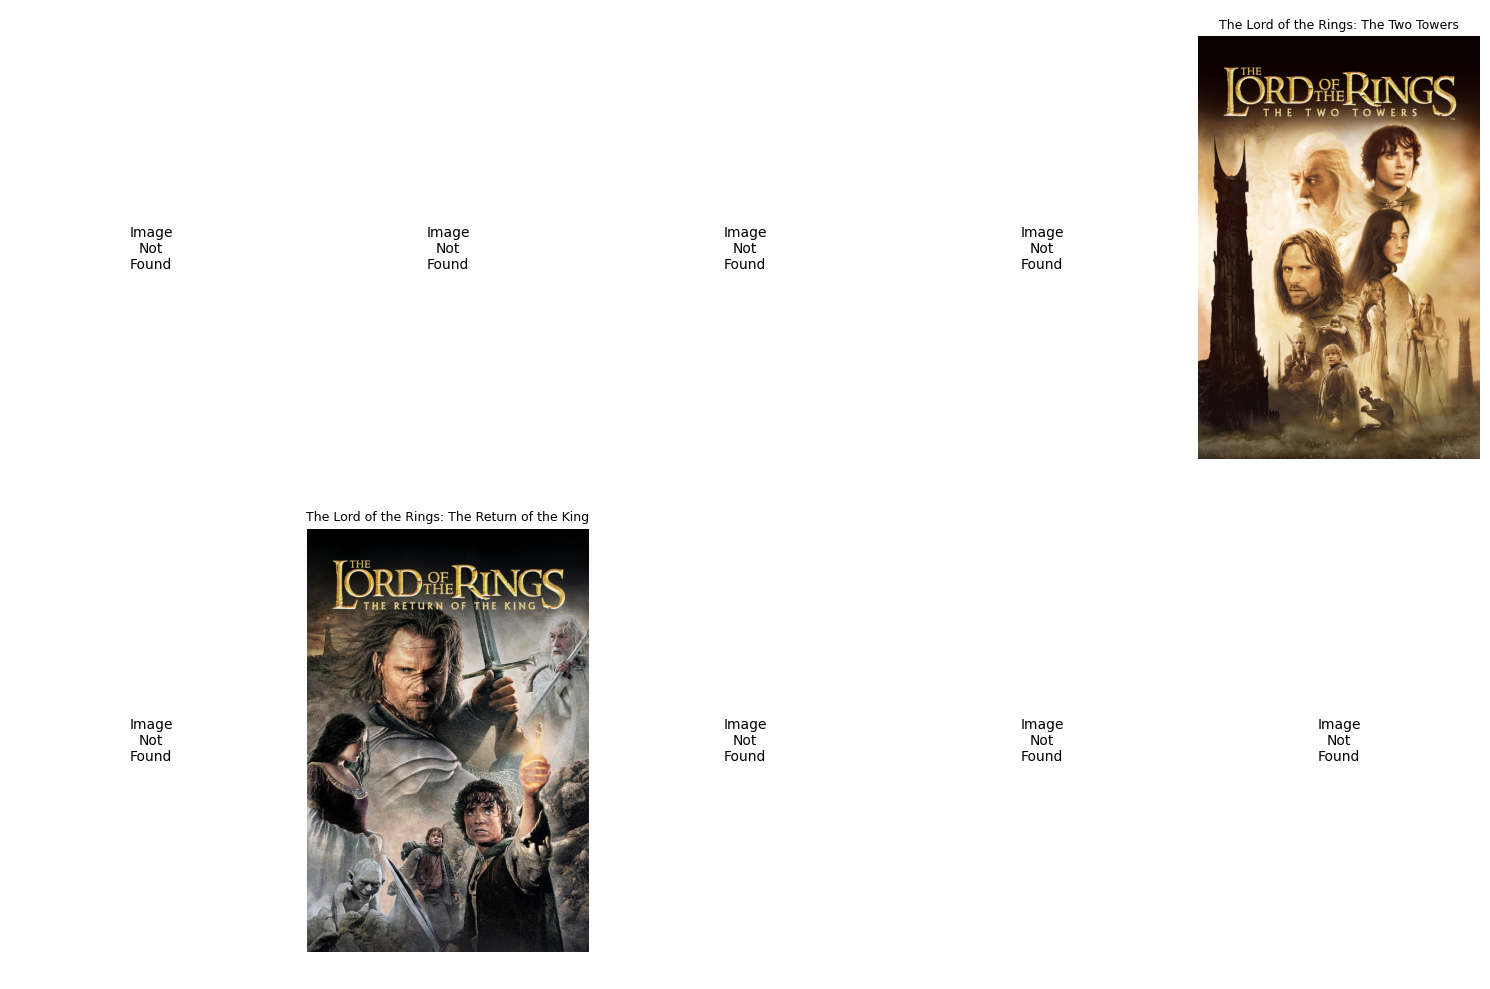

In [44]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


def rec_with_image(title):
    rec_df = item_based_rec(title)
    poster_paths = rec_df['poster_path']
    titles = rec_df['title']  # Assuming your DataFrame has 'title' column
    
    n = len(poster_paths)
    cols = 5  # number of posters per row, adjust for layout
    rows = (n + cols - 1) // cols  # compute rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*5))
    axes = axes.flatten()  # flatten in case of multiple rows
    
    for i, (poster_path, movie_title) in enumerate(zip(poster_paths, titles)):
        full_url = 'https://image.tmdb.org/t/p/original' + poster_path
        response = requests.get(full_url)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            axes[i].imshow(image)
            axes[i].set_title(movie_title, fontsize=9)
            axes[i].axis('off')  # hide axes for cleaner look
        else:
            axes[i].text(0.5, 0.5, 'Image\nNot\nFound', ha='center', va='center')
            axes[i].axis('off')
    
    # Hide any unused axes if n < rows*cols
    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example:
rec_with_image('Star Wars')
		

In [34]:
df1 = df[['title','overview','genres','poster_path','vote_average','vote_count']].copy()
df1['genres'] = df1['genres'].astype(str)
df1 = df1.drop_duplicates().reset_index(drop=True)

In [35]:
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load movie embeddings from .npy
def load_movie_embeddings(path):
    movie_embeddings_np = np.load(path).astype(np.float32)
    return torch.from_numpy(movie_embeddings_np)

# Load embeddings
movie_embeddings = load_movie_embeddings('../model/movie_embeddings.npy')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
movie_embeddings = movie_embeddings.to(device)

# Load sentence embedding model once
model = SentenceTransformer('all-mpnet-base-v2')

# Recommendation function
def recommend_movies(prompt, top_k=10, vote_threshold=150):
    # Encode user query and move to device
    query_embedding = model.encode(prompt, convert_to_tensor=True).to(device)

    # Compute cosine similarity
    cos_scores = util.cos_sim(query_embedding, movie_embeddings)[0]  # shape: (num_movies,)

    # Get top indices (all for now)
    top_results = torch.topk(cos_scores, k=len(cos_scores))
    indices = top_results.indices.cpu().numpy()
    scores = top_results.values.cpu().numpy()

    # Combine with DataFrame
    recommended = df1.iloc[indices].copy()
    recommended['similarity'] = scores

    # Filter: remove duplicates and low vote counts
    recommended = (
        recommended.drop_duplicates(subset='title')
        .query('vote_count > @vote_threshold')
        .sort_values(by='similarity', ascending=False)
        .reset_index(drop=True)
    )

    return recommended[['title', 'similarity', 'overview', 'vote_average', 'vote_count', 'poster_path']].head(top_k)


In [36]:
prompt = "It’s really bleak and dystopian, set in a totalitarian future where everything is monitored, and people aren't allowed to think freely"

In [37]:
recommend_movies(prompt)

,title,similarity,overview,vote_average,vote_count,poster_path
0,The Lives of Others,0.577012,A tragic love story set in East Berlin with th...,7.9,977.0,/bzzDAg3fkztvfQB08VBprhs9tVE.jpg
1,Nineteen Eighty-Four,0.566651,George Orwell's novel of a totalitarian future...,6.8,311.0,/asqIqgy3lywRhrVv6WCdcofNWH1.jpg
2,Following,0.543671,"A struggling, unemployed young writer takes to...",7.2,363.0,/uoWnnSlUIWjqUXxfIej3ucAxg7J.jpg
3,May,0.530801,Psychological horror about a lonely young woma...,6.3,153.0,/kUaoxNyLFhZ8tOKFXu4xQnZJYxa.jpg
4,The Girl with the Dragon Tattoo,0.502649,This English-language adaptation of the Swedis...,7.2,2479.0,/voxRWFTtagLiqnJQs9tWQLB0MN.jpg
5,"Good bye, Lenin!",0.494997,An affectionate and refreshing East/West-Germa...,7.4,602.0,/pb62NJ3tRxgmxBSM9u1Wg1dmmvG.jpg
6,An American Crime,0.494406,The true story of suburban housewife Gertrude ...,7.3,165.0,/62kJ9k0NtRV2QMvZAhl3jdTbnaK.jpg
7,Pi,0.491122,The debut film from Darren Aronofsky in which ...,7.1,600.0,/d4pDorUHjIVFiVGiJar6sF2r8TQ.jpg
8,We Need to Talk About Kevin,0.490354,The mother of a teenage sociopath who went on ...,7.4,687.0,/TBNvX42VMq5vRNppY27mPYEz4Z.jpg
9,Badlands,0.484784,Dramatization of the Starkweather-Fugate killi...,7.5,301.0,/yAFn7Bc80pF98DOxRs85d78jWbD.jpg


In [38]:
def combined_recommendation(input_text):
    if input_text in df['title'].values:
        print(f"Providing item-based recommendations for movie title: {input_text}")
        return item_based_rec(input_text)
    else:
        print(f"Providing content-based recommendations for prompt: {input_text}")
        return recommend_movies(input_text)

# Example usage:
# Providing a movie title
combined_recommendation('Star Wars')


# prompt = "It’s really bleak and dystopian, set in a totalitarian future where everything is monitored, and people aren't allowed to think freely"
# combined_recommendation(prompt)

Providing item-based recommendations for movie title: Star Wars


,title,similarity,vote_count,vote_average,poster_path
0,Return of the Jedi,0.747774,4763.0,7.9,/jx5p0aHlbPXqe3AH9G15NvmWaqQ.jpg
1,The Empire Strikes Back,0.700790,5998.0,8.2,/6u1fYtxG5eqjhtCPDx04pJphQRW.jpg
2,The Lord of the Rings: The Fellowship of the Ring,0.477582,8892.0,8.0,/bxVxZb5O9OxCO0oRUNdCnpy9NST.jpg
3,Raiders of the Lost Ark,0.476442,3949.0,7.7,/44sKJOGP3fTm4QXBcIuqu0RkdP7.jpg
4,The Lord of the Rings: The Two Towers,0.448153,7641.0,8.0,/wf3v0Pn09jnT5HSaYal7Ami3bdA.jpg
5,E.T. the Extra-Terrestrial,0.428289,3359.0,7.3,/8htLKK03TJjKZOXJgihZCu8v0P.jpg
6,The Lord of the Rings: The Return of the King,0.383217,8226.0,8.1,/uexxR7Kw1qYbZk0RYaF9Rx5ykbj.jpg
7,Men in Black,0.341665,4521.0,6.9,/f24UVKq3UiQWLqGWdqjwkzgB8j8.jpg
8,The Lion King,0.337286,5520.0,8.0,/bKPtXn9n4M4s8vvZrbw40mYsefB.jpg
9,Blade Runner,0.333179,3833.0,7.9,/p64TtbZGCElxQHpAMWmDHkWJlH2.jpg


In [ ]:
from fastapi import FastAPI, HTTPException
import torch
import pickle
import pandas as pd
import numpy as np

# --- Define your model class here ---
import torch.nn as nn

class RecSysModel(nn.Module):
    def __init__(self, n_users, n_items, n_genres, embedding_dim=32):
        super(RecSysModel, self).__init__()

        self.user_embed = nn.Embedding(n_users, embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim)

        self.extra_features = nn.Sequential(
            nn.Linear(3, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.genre_features = nn.Sequential(
            nn.Linear(n_genres, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2 + 32 + 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
        )

    def forward(self, user, item, vote_avg, count, popularity, genre):
        user_emb = self.user_embed(user)
        item_emb = self.item_embed(item)

        x_embed = torch.cat([user_emb, item_emb], dim=1)
        x_num = torch.cat([vote_avg.unsqueeze(1), count.unsqueeze(1), popularity.unsqueeze(1)], dim=1)
        x_num = self.extra_features(x_num)
        x_genre = self.genre_features(genre)

        x = torch.cat([x_embed, x_num, x_genre], dim=1)
        out = self.mlp(x)
        return out.squeeze(1)

import pickle
import os

def load_pickle(filepath):
    try:
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        raise
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        raise

user_enc = load_pickle('../model/user_enc.pkl')
item_enc = load_pickle('../model/itemr_enc.pkl')  # fixed typo
scaler = load_pickle('../model/scaler.pkl')
genre2idx = load_pickle('../model/genre2idx.pkl')


# --- Load movie metadata (one row per movie) ---
# Contains at least: title, vote_average, vote_count, popularity, genres (stringified list)
movie_df = pd.read_parquet('../data/movie_data.parquet')

# Convert genres string to list if needed
import ast
def parse_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except Exception:
        return []

movie_df['genres_list'] = movie_df['genres'].apply(parse_genres)

# Multi-hot encode genres
def multi_hot_encode(genres, genre2idx):
    vector = [0] * len(genre2idx)
    for g in genres:
        if g in genre2idx:
            vector[genre2idx[g]] = 1
    return vector

movie_df['genre_vector'] = movie_df['genres_list'].apply(lambda g: multi_hot_encode(g, genre2idx))

# Scale numerical features
movie_df[['vote_avg', 'count', 'popularity_scaled']] = scaler.transform(
    movie_df[['vote_average', 'vote_count', 'popularity']]
)

# Encode item titles
movie_df['title_enc'] = item_enc.transform(movie_df['title'])

# --- Initialize and load model ---
n_users = len(user_enc.classes_)
n_items = len(item_enc.classes_)
n_genres = len(genre2idx)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RecSysModel(n_users, n_items, n_genres)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

/Users/kensukeumamoshi/miniconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kensukeumamoshi/miniconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NameError: name 'itemr_enc' is not defined